# Context R-CNN Demo

<table align="left"><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/tensorflow/models/blob/master/research/object_detection/colab_tutorials/context_rcnn_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/context_rcnn_tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>


 This notebook will walk you step by step through the process of using a pre-trained model to build up a contextual memory bank for a set of images, and then detect objects in those images+context using [Context R-CNN](https://arxiv.org/abs/1912.03538).

# Setup

Important: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md). This notebook includes only what's necessary to run in Colab.

### Install

In [1]:
# !pip install -U --pre tensorflow=="2.*"
# !pip install tf_slim

Make sure you have `pycocotools` installed

In [2]:
# !pip install pycocotools

Get `tensorflow/models` or `cd` to parent directory of the repository.

In [5]:
import os
import pathlib
import tempfile
from six.moves.urllib.request import urlopen
from six.moves.urllib.request import urlopen
from six import BytesIO


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Compile protobufs and install the object_detection package

In [6]:
# %%bash
# !cd models/research/
# !protoc object_detection/protos/*.proto --python_out=.

In [7]:
# %%bash 
# cd models/research
# pip install .

### Imports

In [8]:
import numpy as np
import os
import six
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pathlib
import json
import datetime
import matplotlib.pyplot as plt

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

Import the object detection module.

In [9]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_utils

Patches:

In [10]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Loader

In [11]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name,
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"
  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `zebra`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [12]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/snapshot_serengeti_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=False)

We will test on a context group of images from one month at one camera from the Snapshot Serengeti val split defined on [LILA.science](http://lila.science/datasets/snapshot-serengeti), which was not seen during model training:



In [13]:
# If you want to test the code with your images, just add path to the images to
# the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images/snapshot_serengeti')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpeg")))
TEST_IMAGE_PATHS

[WindowsPath('models/research/object_detection/test_images/snapshot_serengeti/S1_E03_R3_PICT0038.jpeg'),
 WindowsPath('models/research/object_detection/test_images/snapshot_serengeti/S1_E03_R3_PICT0039.jpeg'),
 WindowsPath('models/research/object_detection/test_images/snapshot_serengeti/S1_E03_R3_PICT0040.jpeg'),
 WindowsPath('models/research/object_detection/test_images/snapshot_serengeti/S1_E03_R3_PICT0041.jpeg'),
 WindowsPath('models/research/object_detection/test_images/snapshot_serengeti/S1_E03_R3_PICT0042.jpeg')]

Load the metadata for each image

In [14]:
test_data_json = 'models/research/object_detection/test_images/snapshot_serengeti/context_rcnn_demo_metadata.json'
with open(test_data_json, 'r') as f:
  test_metadata = json.load(f)

In [15]:
image_id_to_datetime = {im['id']:im['date_captured'] for im in test_metadata['images']}
image_path_to_id = {im['file_name']: im['id'] 
                    for im in test_metadata['images']}
image_path_to_id

{'models/research/object_detection/test_images/snapshot_serengeti/S1_E03_R3_PICT0038.jpeg': 'S1/E03/E03_R3/S1_E03_R3_PICT0038',
 'models/research/object_detection/test_images/snapshot_serengeti/S1_E03_R3_PICT0039.jpeg': 'S1/E03/E03_R3/S1_E03_R3_PICT0039',
 'models/research/object_detection/test_images/snapshot_serengeti/S1_E03_R3_PICT0040.jpeg': 'S1/E03/E03_R3/S1_E03_R3_PICT0040',
 'models/research/object_detection/test_images/snapshot_serengeti/S1_E03_R3_PICT0041.jpeg': 'S1/E03/E03_R3/S1_E03_R3_PICT0041'}

# Generate Context Features for each image

In [16]:
faster_rcnn_model_name = 'faster_rcnn_resnet101_snapshot_serengeti_2020_06_10'
faster_rcnn_model = load_model(faster_rcnn_model_name)
# faster_rcnn_model = context_rcnn_model

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Check the model's input signature, it expects a batch of 3-color images of type uint8.

In [17]:
faster_rcnn_model.inputs

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]

And it returns several outputs. Note this model has been exported with additional output 'detection_features' which will be used to build the contextual memory bank.

In [18]:
faster_rcnn_model.output_dtypes

{'raw_detection_boxes': tf.float32,
 'detection_features': tf.float32,
 'num_detections': tf.float32,
 'detection_scores': tf.float32,
 'detection_boxes': tf.float32,
 'raw_detection_scores': tf.float32,
 'detection_multiclass_scores': tf.float32,
 'detection_classes': tf.float32}

In [19]:
faster_rcnn_model.output_shapes

{'raw_detection_boxes': TensorShape([None, 300, 4]),
 'detection_features': TensorShape([None, None, 7, 7, 2048]),
 'num_detections': TensorShape([None]),
 'detection_scores': TensorShape([None, 300]),
 'detection_boxes': TensorShape([None, 300, 4]),
 'raw_detection_scores': TensorShape([None, 300, 49]),
 'detection_multiclass_scores': TensorShape([None, 300, 49]),
 'detection_classes': TensorShape([None, 300])}

Add a wrapper function to call the model, and cleanup the outputs:

In [30]:
def run_inference_for_single_image(model, image):
  '''Run single image through tensorflow object detection saved_model.

  This function runs a saved_model on a (single) provided image and returns
  inference results in numpy arrays.

  Args:
    model: tensorflow saved_model. This model can be obtained using 
      export_inference_graph.py.
    image: uint8 numpy array with shape (img_height, img_width, 3)

  Returns:
    output_dict: a dictionary holding the following entries:
      `num_detections`: an integer
      `detection_boxes`: a numpy (float32) array of shape [N, 4]
      `detection_classes`: a numpy (uint8) array of shape [N]
      `detection_scores`: a numpy (float32) array of shape [N]
      `detection_features`: a numpy (float32) array of shape [N, 7, 7, 2048]
  '''
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)
  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_dets = output_dict.pop('num_detections')
  num_detections = int(num_dets)
  for key,value in output_dict.items():
    output_dict[key] = value[0, :num_detections].numpy() 
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(
      np.int64)
  return output_dict

In [31]:
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

Functions for embedding context features

In [32]:
def embed_date_captured(date_captured):
  """Encodes the datetime of the image.

  Takes a datetime object and encodes it into a normalized embedding of shape 
  [5], using hard-coded normalization factors for year, month, day, hour,
  minute.

  Args:
    date_captured: A datetime object.

  Returns:
    A numpy float32 embedding of shape [5].
  """
  embedded_date_captured = []
  month_max = 12.0
  day_max = 31.0
  hour_max = 24.0
  minute_max = 60.0
  min_year = 1990.0
  max_year = 2030.0

  year = (date_captured.year-min_year)/float(max_year-min_year)
  embedded_date_captured.append(year)

  month = (date_captured.month-1)/month_max
  embedded_date_captured.append(month)

  day = (date_captured.day-1)/day_max
  embedded_date_captured.append(day)

  hour = date_captured.hour/hour_max
  embedded_date_captured.append(hour)

  minute = date_captured.minute/minute_max
  embedded_date_captured.append(minute)

  return np.asarray(embedded_date_captured)

In [33]:
def embed_position_and_size(box):
  """Encodes the bounding box of the object of interest.

  Takes a bounding box and encodes it into a normalized embedding of shape 
  [4] - the center point (x,y) and width and height of the box.

  Args:
    box: A bounding box, formatted as [ymin, xmin, ymax, xmax].

  Returns:
    A numpy float32 embedding of shape [4].
  """
  ymin = box[0]
  xmin = box[1]
  ymax = box[2]
  xmax = box[3]
  w = xmax - xmin
  h = ymax - ymin
  x = xmin + w / 2.0
  y = ymin + h / 2.0
  return np.asarray([x, y, w, h])

In [34]:
def get_context_feature_embedding(date_captured, detection_boxes,
                                  detection_features, detection_scores):
  """Extracts representative feature embedding for a given input image.

  Takes outputs of a detection model and focuses on the highest-confidence
  detected object. Starts with detection_features and uses average pooling to
  remove the spatial dimensions, then appends an embedding of the box position
  and size, and an embedding of the date and time the image was captured,
  returning a one-dimensional representation of the object.

  Args:
    date_captured: A datetime string of format '%Y-%m-%d %H:%M:%S'.
    detection_features: A numpy (float32) array of shape [N, 7, 7, 2048].
    detection_boxes: A numpy (float32) array of shape [N, 4].
    detection_scores: A numpy (float32) array of shape [N].

  Returns:
    A numpy float32 embedding of shape [2057].
  """
  date_captured = datetime.datetime.strptime(date_captured,'%Y-%m-%d %H:%M:%S')
  temporal_embedding = embed_date_captured(date_captured)
  embedding = detection_features[0]
  pooled_embedding = np.mean(np.mean(embedding, axis=1), axis=0)
  box = detection_boxes[0]
  position_embedding = embed_position_and_size(box)
  bb_embedding = np.concatenate((pooled_embedding, position_embedding))
  embedding = np.expand_dims(np.concatenate((bb_embedding,temporal_embedding)),
                             axis=0)
  score = detection_scores[0]
  return embedding, score

Run it on each test image and use the output detection features and metadata to build up a context feature bank:

In [35]:
def run_inference_for_single_image(model, image):
  '''Run single image through tensorflow object detection saved_model.

  This function runs a saved_model on a (single) provided image and returns
  inference results in numpy arrays.

  Args:
    model: tensorflow saved_model. This model can be obtained using 
      export_inference_graph.py.
    image: uint8 numpy array with shape (img_height, img_width, 3)

  Returns:
    output_dict: a dictionary holding the following entries:
      `num_detections`: an integer
      `detection_boxes`: a numpy (float32) array of shape [N, 4]
      `detection_classes`: a numpy (uint8) array of shape [N]
      `detection_scores`: a numpy (float32) array of shape [N]
      `detection_features`: a numpy (float32) array of shape [N, 7, 7, 2048]
  '''
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)
  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_dets = output_dict.pop('num_detections')
  num_detections = int(num_dets)
  for key,value in output_dict.items():
    output_dict[key] = value[0, :num_detections].numpy() 
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(
      np.int64)
  return output_dict

In [41]:
def run_inference(model, image_path, date_captured, resize_image=True):
  """Runs inference over a single input image and extracts contextual features.

  Args:
    model: A tensorflow saved_model object.
    image_path: Absolute path to the input image.
    date_captured: A datetime string of format '%Y-%m-%d %H:%M:%S'.
    resize_image: Whether to resize the input image before running inference.

  Returns:
    context_feature: A numpy float32 array of shape [2057].
    score: A numpy float32 object score for the embedded object.
    output_dict: The saved_model output dictionary for the image.
  """
  with open(image_path,'rb') as f:
    image = Image.open(f)
    if resize_image:
      image.thumbnail((640,640),Image.ANTIALIAS)
    image_np = np.array(image)

  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)

  context_feature, score = get_context_feature_embedding(
      date_captured, output_dict['detection_boxes'],
      output_dict['detection_features'], output_dict['detection_scores'])
  return context_feature, score, output_dict

In [36]:
image_id_to_datetime['S1/E03/E03_R3/S1_E03_R3_PICT0042'] = '2010-08-07 02:53:46'

In [44]:
image_path_to_id['models/research/object_detection/test_images/snapshot_serengeti/S1_E03_R3_PICT0042.jpeg'] = 'S1/E03/E03_R3/S1_E03_R3_PICT0041'
image_path_to_id

{'models/research/object_detection/test_images/snapshot_serengeti/S1_E03_R3_PICT0038.jpeg': 'S1/E03/E03_R3/S1_E03_R3_PICT0038',
 'models/research/object_detection/test_images/snapshot_serengeti/S1_E03_R3_PICT0039.jpeg': 'S1/E03/E03_R3/S1_E03_R3_PICT0039',
 'models/research/object_detection/test_images/snapshot_serengeti/S1_E03_R3_PICT0040.jpeg': 'S1/E03/E03_R3/S1_E03_R3_PICT0040',
 'models/research/object_detection/test_images/snapshot_serengeti/S1_E03_R3_PICT0041.jpeg': 'S1/E03/E03_R3/S1_E03_R3_PICT0041',
 'models/research/object_detection/test_images/snapshot_serengeti/S1_E03_R3_PICT0042.jpeg': 'S1/E03/E03_R3/S1_E03_R3_PICT0041'}

In [45]:
image_id_to_datetime

{'S1/E03/E03_R3/S1_E03_R3_PICT0038': '2010-08-07 01:04:14',
 'S1/E03/E03_R3/S1_E03_R3_PICT0039': '2010-08-07 01:04:14',
 'S1/E03/E03_R3/S1_E03_R3_PICT0040': '2010-08-07 02:53:46',
 'S1/E03/E03_R3/S1_E03_R3_PICT0041': '2010-08-07 02:53:46',
 'S1/E03/E03_R3/S1_E03_R3_PICT0042': '2010-08-07 02:53:46'}

In [46]:
context_features = []
scores = []
faster_rcnn_results = {}
for image_path in TEST_IMAGE_PATHS:
#   image_id = str(image_path).replace(os.sep,'/')
  image_id = image_path_to_id[str(image_path).replace(os.sep,'/')]
  date_captured = image_id_to_datetime[image_id]
#   data_capture = '2010-08-07 02:53:46'
  context_feature, score, results = run_inference(
      faster_rcnn_model, image_path, date_captured)
  faster_rcnn_results[image_id] = results
  context_features.append(context_feature)
  scores.append(score)

# Concatenate all extracted context embeddings into a contextual memory bank.
context_features_matrix = np.concatenate(context_features, axis=0)


## Run Detection With Context

Load a context r-cnn object detection model:

In [56]:
context_rcnn_model_name = 'context_rcnn_resnet101_snapshot_serengeti_2020_06_10'
context_rcnn_model_name = 'faster_rcnn_nas'
context_rcnn_model = load_model(context_rcnn_model_name)


Exception: URL fetch failure on http://download.tensorflow.org/models/object_detection/faster_rcnn_nas.tar.gz: 403 -- Forbidden

We need to define the expected context padding size for the
model, this must match the definition in the model config (max_num_context_features).

In [48]:
context_padding_size = 2000

Check the model's input signature, it expects a batch of 3-color images of type uint8, plus context_features padded to the maximum context feature size for this model (2000) and valid_context_size to represent the non-padded context features: 

In [49]:
context_rcnn_model.inputs

[<tf.Tensor 'context_features:0' shape=(1, 2000, 2057) dtype=float32>,
 <tf.Tensor 'image_tensor:0' shape=(1, None, None, 3) dtype=uint8>,
 <tf.Tensor 'valid_context_size:0' shape=(1,) dtype=int32>]

And returns several outputs:

In [50]:
context_rcnn_model.output_dtypes

{'raw_detection_boxes': tf.float32,
 'detection_scores': tf.float32,
 'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'raw_detection_scores': tf.float32,
 'detection_multiclass_scores': tf.float32,
 'num_detections': tf.float32}

In [51]:
context_rcnn_model.output_shapes

{'raw_detection_boxes': TensorShape([1, 300, 4]),
 'detection_scores': TensorShape([1, 300]),
 'detection_boxes': TensorShape([1, 300, 4]),
 'detection_classes': TensorShape([1, 300]),
 'raw_detection_scores': TensorShape([1, 300, 49]),
 'detection_multiclass_scores': TensorShape([1, 300, 49]),
 'num_detections': TensorShape([1])}

In [52]:
def run_context_rcnn_inference_for_single_image(
    model, image, context_features, context_padding_size):
  '''Run single image through a Context R-CNN saved_model.

  This function runs a saved_model on a (single) provided image and provided 
  contextual features and returns inference results in numpy arrays.

  Args:
    model: tensorflow Context R-CNN saved_model. This model can be obtained
      using export_inference_graph.py and setting side_input fields. 
      Example export call - 
        python export_inference_graph.py \
          --input_type image_tensor \
          --pipeline_config_path /path/to/context_rcnn_model.config \
          --trained_checkpoint_prefix /path/to/context_rcnn_model.ckpt \
          --output_directory /path/to/output_dir \
          --use_side_inputs True \
          --side_input_shapes 1,2000,2057/1 \
          --side_input_names context_features,valid_context_size \
          --side_input_types float,int \
          --input_shape 1,-1,-1,3

    image: uint8 numpy array with shape (img_height, img_width, 3)
    context_features: A numpy float32 contextual memory bank of shape 
      [num_context_examples, 2057]
    context_padding_size: The amount of expected padding in the contextual
      memory bank, defined in the Context R-CNN config as 
      max_num_context_features.

  Returns:
    output_dict: a dictionary holding the following entries:
      `num_detections`: an integer
      `detection_boxes`: a numpy (float32) array of shape [N, 4]
      `detection_classes`: a numpy (uint8) array of shape [N]
      `detection_scores`: a numpy (float32) array of shape [N]
  '''
  image = np.asarray(image)
  # The input image needs to be a tensor, convert it using 
  # `tf.convert_to_tensor`.
  image_tensor = tf.convert_to_tensor(
      image, name='image_tensor')[tf.newaxis,...]

  context_features = np.asarray(context_features)
  valid_context_size = context_features.shape[0]
  valid_context_size_tensor = tf.convert_to_tensor(
      valid_context_size, name='valid_context_size')[tf.newaxis,...]
  padded_context_features = np.pad(
      context_features,
      ((0,context_padding_size-valid_context_size),(0,0)), mode='constant')
  padded_context_features_tensor = tf.convert_to_tensor(
      padded_context_features,
      name='context_features',
      dtype=tf.float32)[tf.newaxis,...]

  # Run inference
  output_dict = model(
      inputs=image_tensor,
      context_features=padded_context_features_tensor,
      valid_context_size=valid_context_size_tensor)
  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_dets = output_dict.pop('num_detections')
  num_detections = int(num_dets)
  for key,value in output_dict.items():
    output_dict[key] = value[0, :num_detections].numpy() 
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
  return output_dict

In [53]:
def show_context_rcnn_inference(
    model, image_path, context_features, faster_rcnn_output_dict,
    context_padding_size, resize_image=True):
  """Runs inference over a single input image and visualizes Faster R-CNN vs. 
  Context R-CNN results.

  Args:
    model: A tensorflow saved_model object.
    image_path: Absolute path to the input image.
    context_features: A numpy float32 contextual memory bank of shape 
      [num_context_examples, 2057]
    faster_rcnn_output_dict: The output_dict corresponding to this input image
      from the single-frame Faster R-CNN model, which was previously used to
      build the memory bank.
    context_padding_size: The amount of expected padding in the contextual
      memory bank, defined in the Context R-CNN config as 
      max_num_context_features.
    resize_image: Whether to resize the input image before running inference.

  Returns:
    context_rcnn_image_np: Numpy image array showing Context R-CNN Results.
    faster_rcnn_image_np: Numpy image array showing Faster R-CNN Results.
  """

  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  with open(image_path,'rb') as f:
    image = Image.open(f)
    if resize_image:
      image.thumbnail((640,640),Image.ANTIALIAS)
    image_np = np.array(image)
    image.thumbnail((400,400),Image.ANTIALIAS)
    context_rcnn_image_np = np.array(image)
    
  faster_rcnn_image_np = np.copy(context_rcnn_image_np)

  # Actual detection.
  output_dict = run_context_rcnn_inference_for_single_image(
      model, image_np, context_features, context_padding_size)

  # Visualization of the results of a context_rcnn detection.
  vis_utils.visualize_boxes_and_labels_on_image_array(
      context_rcnn_image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      line_thickness=2)
  
  # Visualization of the results of a faster_rcnn detection.
  vis_utils.visualize_boxes_and_labels_on_image_array(
      faster_rcnn_image_np,
      faster_rcnn_output_dict['detection_boxes'],
      faster_rcnn_output_dict['detection_classes'],
      faster_rcnn_output_dict['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      line_thickness=2)
  return context_rcnn_image_np, faster_rcnn_image_np

Define Matplotlib parameters for pretty visualizations

In [54]:
%matplotlib inline
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [15,10]

Run Context R-CNN inference and compare results to Faster R-CNN

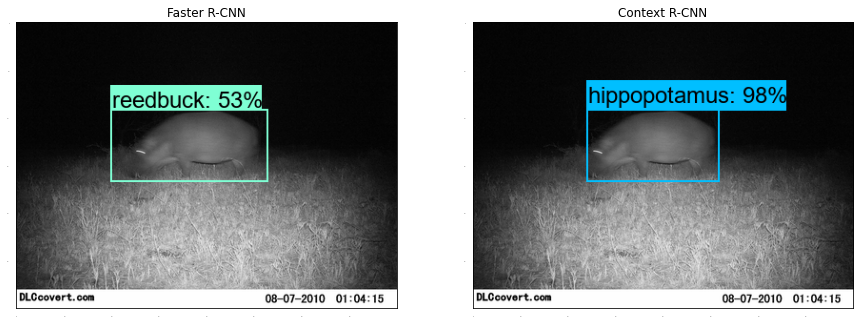

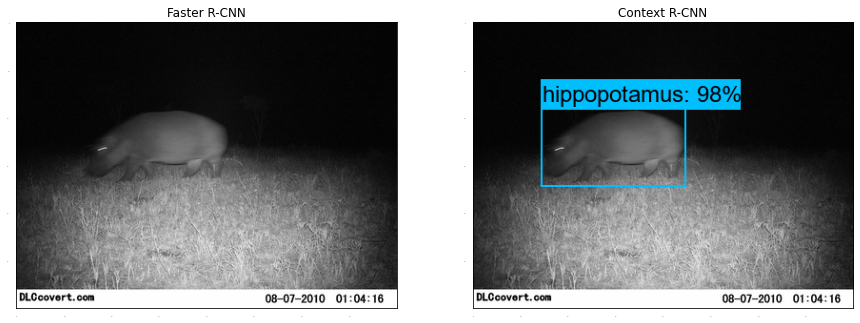

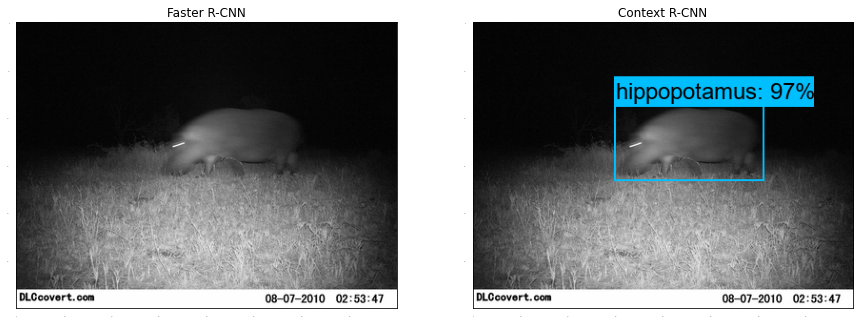

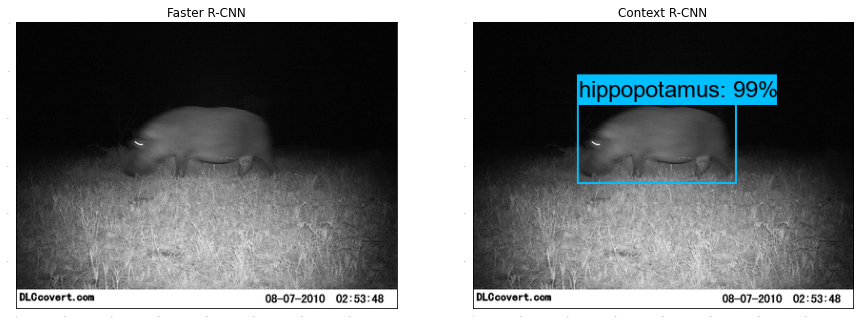

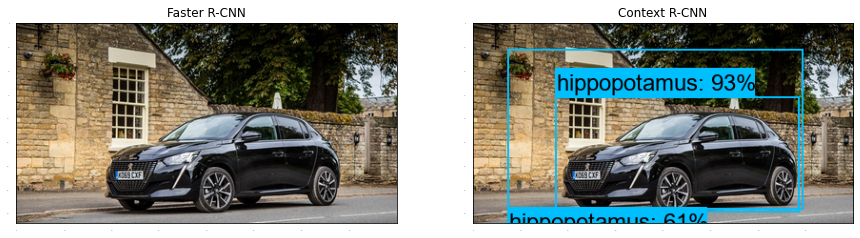

In [55]:
for image_path in TEST_IMAGE_PATHS:
  image_id = image_path_to_id[str(image_path).replace(os.sep,'/')]
#   image_id = str(image_path).replace(os.sep,'/')
  faster_rcnn_output_dict = faster_rcnn_results[image_id]
  context_rcnn_image, faster_rcnn_image = show_context_rcnn_inference(
      context_rcnn_model, image_path, context_features_matrix,
      faster_rcnn_output_dict, context_padding_size)
  plt.subplot(1,2,1)
  plt.imshow(faster_rcnn_image)
  plt.title('Faster R-CNN')
  plt.subplot(1,2,2)
  plt.imshow(context_rcnn_image)
  plt.title('Context R-CNN')
  plt.show()

The images used in this demo are from the [Snapshot Serengeti dataset](http://lila.science/datasets/snapshot-serengeti), and released under the [Community Data License Agreement (permissive variant)](https://cdla.io/permissive-1-0/).

In [402]:
image_id_to_datetime

{'S1/E03/E03_R3/S1_E03_R3_PICT0038': '2010-08-07 01:04:14',
 'S1/E03/E03_R3/S1_E03_R3_PICT0039': '2010-08-07 01:04:14',
 'S1/E03/E03_R3/S1_E03_R3_PICT0040': '2010-08-07 02:53:46',
 'S1/E03/E03_R3/S1_E03_R3_PICT0041': '2010-08-07 02:53:46'}

In [ ]:
# image_id_to_datetime[] = '2010-08-07 02:53:46'

In [193]:
# image_id_to_datetime['S1/E03/E03_R3/S1_E03_R3_PICT0041']

'2010-08-07 02:53:46'

In [297]:
run_inference_for_image(context_rcnn_model,
            'models/research/object_detection/test_images/snapshot_serengeti/S1_E03_R3_PICT0041.jpeg')

TypeError: pruned(context_features, inputs, valid_context_size) takes 0 positional arguments, got 1.

In [278]:
str('models/research/object_detection/test_images/snapshot_serengeti/S1_E03_R3_PICT0041.jpeg').replace(os.sep,'/')

'models/research/object_detection/test_images/snapshot_serengeti/S1_E03_R3_PICT0041.jpeg'